In [1]:
import json
from os.path import dirname, join
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import xgi

In [2]:
dataset_name = "arxiv-kaggle"

In [ ]:
with open("index.json") as file:
    jsondata = json.load(file)
baseurl = jsondata[dataset_name]["url"]

try:
    H = xgi.from_hif_dict(xgi.request_json_from_url(baseurl))
    stats = {}
except KeyError:
    if (
        "data-type" in jsondata[dataset_name]
        and jsondata[dataset_name]["data-type"] == "collection"
    ):
        H = {}
        stats = {"datasets": {}}
        for key, data in xgi.request_json_from_url(baseurl)["datasets"].items():
            relpath = data["relative-path"]
            url = join(dirname(baseurl), relpath)
            H[key] = xgi.from_hypergraph_dict(xgi.request_json_from_url(url))
            stats["datasets"][key] = {"url": url}
    else:
        H = xgi.from_hypergraph_dict(xgi.request_json_from_url(baseurl))
        stats = {}

In [ ]:
if isinstance(H, xgi.Hypergraph):
    stats.update(
        {
            "num-nodes": int(H.num_nodes),
            "num-edges": int(H.num_edges),
        }
    )
elif isinstance(H, dict):
    for key, net in H.items():
        stats["datasets"][key].update(
            {
                "num-nodes": int(net.num_nodes),
                "num-edges": int(net.num_edges),
            }
        )

In [6]:
if isinstance(H, xgi.Hypergraph):
    simpleH = H.copy()
    simpleH.merge_duplicate_edges()
    stats.update(
        {
            "num-unique-edges": int(simpleH.num_edges),
        }
    )
elif isinstance(H, dict):
    for key, net in H.items():
        simpleH = net.copy()
        simpleH.merge_duplicate_edges()
        stats["datasets"][key].update(
            {
                "num-unique-edges": int(simpleH.num_edges),
            }
        )

In [7]:
if isinstance(H, xgi.Hypergraph):
    s = H.edges.size
    stats.update(
        {
            "min-edge-size": int(s.min()),
            "max-edge-size": int(s.max()),
            "mean-edge-size": round(s.mean(), 2),
        }
    )
elif isinstance(H, dict):
    for key, net in H.items():
        s = net.edges.size
        stats["datasets"][key].update(
            {
                "min-edge-size": int(s.min()),
                "max-edge-size": int(s.max()),
                "mean-edge-size": round(s.mean(), 2),
            }
        )

In [8]:
if isinstance(H, xgi.Hypergraph):
    d = H.nodes.degree
    stats.update(
        {
            "min-degree": int(d.min()),
            "max-degree": int(d.max()),
            "mean-degree": round(d.mean(), 2),
        }
    )
elif isinstance(H, dict):
    for key, net in H.items():
        d = net.nodes.degree
        stats["datasets"][key].update(
            {
                "min-degree": int(s.min()),
                "max-degree": int(d.max()),
                "mean-degree": round(d.mean(), 2),
            }
        )

In [9]:
if isinstance(H, xgi.Hypergraph):
    cc = [len(c) for c in xgi.connected_components(H)]
    stats.update(
        {
            "num-components": len(cc),
            "gc-size": max(cc),
        }
    )
elif isinstance(H, dict):
    for key, net in H.items():
        cc = [len(c) for c in xgi.connected_components(net)]
        stats["datasets"][key].update(
            {
                "num-components": len(cc),
                "gc-size": max(cc),
            }
        )

In [10]:
with open("index.json") as file:
    data = json.load(file)

data[dataset_name].update(stats)

datastring = json.dumps(data, indent=2)

with open("index.json", "w") as output_file:
    output_file.write(datastring)

In [11]:
def plot_distributions(
    H,
    node_bins=None,
    edge_bins=None,
    log_x1=True,
    log_y1=True,
    log_x2=True,
    log_y2=True,
):

    if node_bins is None:
        node_bins = int(H.num_nodes / 20)
        node_bins = min(node_bins, 100)

    if edge_bins is None:
        s = H.edges.size
        edge_bins = int(s.max() - s.min() + 1)
        edge_bins = min(edge_bins, 100)

    plt.figure(figsize=(8, 4))
    plt.subplot(121)

    h1 = H.nodes.degree.ashist(bins=node_bins, density=True, log_binning=log_x1)
    h2 = H.edges.size.ashist(bins=edge_bins, density=True, log_binning=log_x2)
    y1 = h1[h1.value > 0].value
    y2 = h2[h2.value > 0].value
    ymin = 0.95 * min(y1.min(), y2.min())
    ymax = 1.1 * max(y1.max(), y2.max())

    if log_x1 and log_y1:
        plt.loglog(h1["bin_center"], h1["value"], "ko", markersize=2)
    elif log_x1 and not log_y1:
        plt.semilogx(h1["bin_center"], h1["value"], "ko", markersize=2)
    elif not log_x1 and log_y1:
        plt.semilogy(h1["bin_center"], h1["value"], "ko", markersize=2)
    elif not log_x1 and not log_y1:
        plt.plot(h1["bin_center"], h1["value"], "ko", markersize=2)

    plt.title("Degree distribution")
    plt.xlabel(r"$k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    plt.ylim([ymin, ymax])
    sns.despine()

    plt.subplot(122)

    if log_x2 and log_y2:
        plt.loglog(h2["bin_center"], h2["value"], "ko", markersize=2)
    elif log_x2 and not log_y2:
        plt.semilogx(h2["bin_center"], h2["value"], "ko", markersize=2)
    elif not log_x2 and log_y2:
        plt.semilogy(h2["bin_center"], h2["value"], "ko", markersize=2)
    elif not log_x2 and not log_y2:
        plt.plot(h2["bin_center"], h2["value"], "ko", markersize=2)

    plt.title("Edge size distribution")
    plt.xlabel(r"$s$", fontsize=16)
    plt.ylabel(r"$P(s)$", fontsize=16)
    plt.ylim([ymin, ymax])
    sns.despine()
    plt.tight_layout()
    Path(f"datasheets/{dataset_name}").mkdir(parents=True, exist_ok=True)
    plt.savefig(f"datasheets/{dataset_name}/stats.png", dpi=300)
    plt.show()

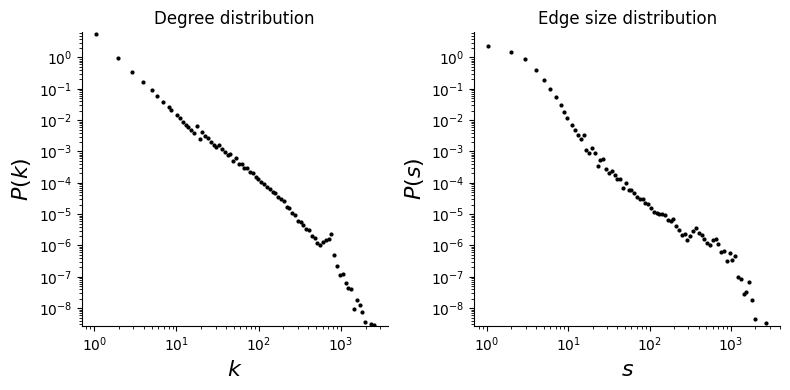

In [12]:
plot_distributions(H, log_x1=True, log_y1=True, log_x2=True, log_y2=True)